# ARIMA Model Comparison With Data From Different Domains
This notebook demonstrates how to run the prediction models on financial data

ARIMA is represented by three parameters: p, d, and q:

p: The number of past values (lags) considered in the AR term.

d: The degree of differencing applied to the data.

q: The number of past forecast errors included in the MA term.

order = (p,d,q) order of the model for the autoregressive, differences, and moving average components. d is always an integer, while p and q may either be integers or lists of integers.


In [1]:
import sys
import os

%matplotlib inline

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.base_ARIMA import run_arima_on_dataset

from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2

# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import RobustScaler

# from statsmodels.tsa.arima.model import ARIMA
# from math import sqrt

In [3]:
finance_data = pd.read_csv('../data/dataset_finance/processed/processed_finance_data.csv')

finance_data

,Date,Close_TSLA,Volume_TSLA,TSLA_Returns,TSLA_day,TSLA_month,TSLA_weekday,day_sin,day_cos,month_sin,...,Close_SOXX,Volume_SOXX,SOXX_Returns,PCE_Price_Index,Core_PCE_Price_Index,10-Year_Treasury_Yield,Federal_Funds_Rate,University_of_Michigan-Consumer_Sentiment,Consumer_Price_Index-All_Items-Total_for_United_States,Total_Vehicle_Sales
0,2014-09-17,17.425333,77665500.0,0.002454,17.0,9.0,2.0,-0.299363,-0.954139,-1.000000,...,26.093210,444000.0,0.007184,97.413,96.013,2.62,0.09,84.6,0.075257,16.959
1,2014-09-18,17.587999,55389000.0,0.009335,18.0,9.0,3.0,-0.485302,-0.874347,-1.000000,...,26.492056,355500.0,0.015285,97.413,96.013,2.63,0.09,84.6,0.075257,16.959
2,2014-09-19,17.288000,102163500.0,-0.017057,19.0,9.0,4.0,-0.651372,-0.758758,-1.000000,...,26.161163,339000.0,-0.012490,97.413,96.013,2.59,0.09,84.6,0.075257,16.959
3,2014-09-22,16.668667,123211500.0,-0.035824,22.0,9.0,0.0,-0.968077,-0.250653,-1.000000,...,25.845039,315600.0,-0.012084,97.413,96.013,2.57,0.09,84.6,0.075257,16.959
4,2014-09-23,16.694000,84880500.0,0.001520,23.0,9.0,1.0,-0.998717,-0.050649,-1.000000,...,25.762320,632700.0,-0.003201,97.413,96.013,2.54,0.09,84.6,0.075257,16.959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,2024-02-26,199.399994,111747100.0,0.038704,26.0,2.0,0.0,-0.848644,0.528964,0.866025,...,212.632172,3759000.0,0.009867,122.494,121.418,4.28,5.33,76.9,0.618967,16.177
2374,2024-02-27,199.729996,108645400.0,0.001655,27.0,2.0,1.0,-0.724793,0.688967,0.866025,...,212.420441,4560900.0,-0.000996,122.494,121.418,4.31,5.33,76.9,0.618967,16.177
2375,2024-02-28,202.039993,99806200.0,0.011566,28.0,2.0,2.0,-0.571268,0.820763,0.866025,...,210.031952,2923800.0,-0.011244,122.494,121.418,4.27,5.33,76.9,0.618967,16.177
2376,2024-02-29,201.880005,85907000.0,-0.000792,29.0,2.0,3.0,-0.394356,0.918958,0.866025,...,215.721985,3382800.0,0.027091,122.494,121.418,4.25,5.33,76.9,0.618967,16.177


[Before Model Training] Memory Usage: 448.82 MB | CPU Usage: 0.00%


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

MLE did not converge for Finance. Details: {'fopt': -0.5276584804267508, 'gopt': array([ 1.65243508e+12, -1.84517063e-02, -2.07808199e+00,  1.47035564e-01,
       -1.77337350e-01,  1.85285850e-02,  3.86436332e-02, -4.68788283e-03,
        2.12654326e-02, -6.43320032e-03,  6.80415031e-02,  3.62764853e+00,
       -5.44747972e+00,  2.07774341e+00,  1.35148655e+00, -6.61256162e+00,
        4.80977650e+00, -1.76026265e+00, -9.02701570e-01,  1.29301569e-01,
       -7.35351385e-01,  3.65090184e-01, -1.84517077e-02,  6.12927904e-02,
       -2.98743106e-02,  3.04249946e-02,  2.11726355e-02,  4.78239174e-02,
        8.44657088e-03, -1.40926658e-02,  2.71942488e+00,  5.16299661e-02,
        2.71416769e-02,  4.55269283e-02, -1.39681645e-02,  3.56219187e-04,
        2.98605157e-03,  7.58772648e-03,  3.39344920e-03,  8.73517933e-02,
        1.11042734e-01,  6.39265897e-02,  7.02584760e-01,  9.96284932e-02,
       -9.54960184e-01, -5.46872522e-01, -3.62325148e-01, -7.87996444e-02,
        7.37643482e

c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[After Model Training] Memory Usage: 463.98 MB | CPU Usage: 0.00%

[ARIMA - Finance] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 25.954
MAE                 : 24.023
MAPE (%)            : nan
R²                  : 0.795
Adjusted R²         : 0.769
Training Time (s)   : 17.63
Memory Used (MB)    : 15.15
Device Used         : CPU
---------------------------------------------------------------------------


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:90: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100


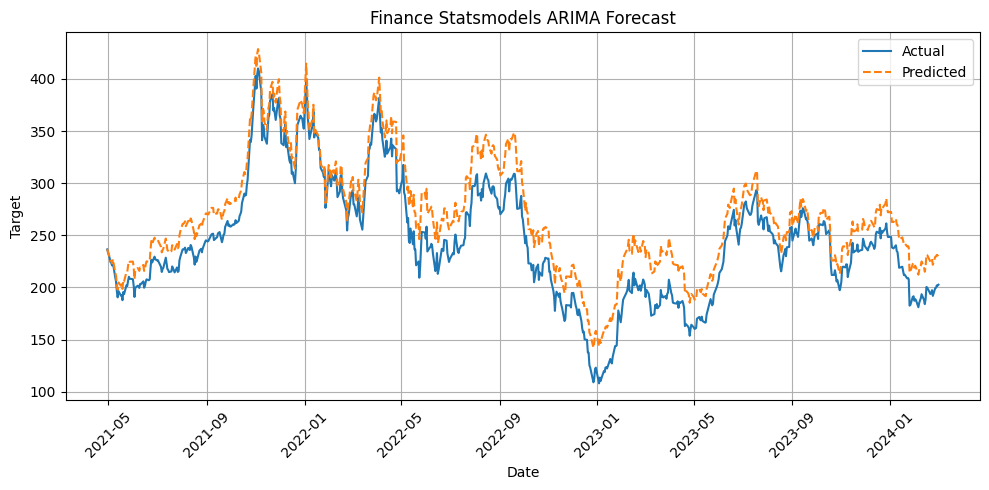

{'Dataset': 'Finance',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Close_TSLA',
 'RMSE': 25.95396577560627,
 'MSE': 673.6083394813417,
 'MAE': 24.022785599042027,
 'MAPE': nan,
 'R²': 0.7951970893093468,
 'Adj_R²': 0.7685824479834616,
 'TrainingTime_s': 17.63062047958374,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 463.9765625}

In [4]:
# Run ARIMA Model on Finance Data

# Define parameters for ARIMA model
finance_data.name = "Finance"
target = "Close_TSLA"  # Target variable to predict
date_col = "Date"  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model # or "pmdarima"
order=(5, 1, 0)  # ARIMA order (p, d, q)

finance_arima_results = run_arima_on_dataset(
    finance_data,
    target,
    date_col,
    test_ratio,
    engine,  
    order
)

finance_arima_results

In [5]:
# load parquet data to pandas dataframe
retail_data = pd.read_parquet('../data/dataset_retail/processed/data_with_lags_s1_i1.parquet')
retail_data	= retail_data.drop(columns=['split'])

retail_data

,date,sales,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_month_start,...,sales_roll_mean_60d,sales_roll_std_60d,sales_roll_median_60d,sales_roll_min_60d,sales_roll_max_60d,sales_roll_mean_90d,sales_roll_std_90d,sales_roll_median_90d,sales_roll_min_90d,sales_roll_max_90d
0,2014-01-01,9,2014,1,1,2,1,1,1,1,...,15.416667,5.645732,16.0,5.0,31.0,15.733333,5.120569,16.0,5.0,31.0
1,2014-01-02,14,2014,1,2,3,2,1,1,0,...,15.333333,5.628820,16.0,5.0,31.0,15.733333,5.120569,16.0,5.0,31.0
2,2014-01-03,11,2014,1,3,4,3,1,1,0,...,15.316667,5.640326,16.0,5.0,31.0,15.700000,5.141700,16.0,5.0,31.0
3,2014-01-04,20,2014,1,4,5,4,1,1,0,...,15.316667,5.640326,16.0,5.0,31.0,15.700000,5.141700,16.0,5.0,31.0
4,2014-01-05,17,2014,1,5,6,5,1,1,0,...,15.333333,5.643856,16.0,5.0,31.0,15.744444,5.135383,16.0,5.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2017-12-27,14,2017,12,27,2,361,52,4,0,...,19.866667,6.261171,19.0,6.0,34.0,20.193182,5.908999,20.0,6.0,34.0
1457,2017-12-28,19,2017,12,28,3,362,52,4,0,...,19.700000,6.145965,19.0,6.0,34.0,20.179775,5.876691,20.0,6.0,34.0
1458,2017-12-29,15,2017,12,29,4,363,52,4,0,...,19.583333,6.167964,19.0,6.0,34.0,20.122222,5.869035,20.0,6.0,34.0
1459,2017-12-30,27,2017,12,30,5,364,52,4,0,...,19.633333,6.216344,19.0,6.0,34.0,20.188889,5.913030,20.0,6.0,34.0


[Before Model Training] Memory Usage: 466.70 MB | CPU Usage: 0.00%


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MLE did not converge for Retail. Details: {'fopt': 2.5057076477379967, 'gopt': array([-3.97926136e-05, -4.01572065e-04,  3.01967454e-02, -1.98747135e-02,
        1.68416282e-02, -4.16503645e-03, -9.84650805e-04, -1.59932907e-03,
        1.02260942e-03,  1.20596014e-02, -5.09288990e-02, -2.94678110e-02,
       -1.33905733e-02,  5.39885336e-03, -9.03585917e-04,  3.33342860e-03,
        2.63697822e-02, -9.37939602e-03,  2.70947940e-02, -4.39757790e-03,
        4.15244772e-03, -8.94110808e-03,  9.51390966e-04, -1.14090414e-02,
       -1.71721775e-02, -8.74886519e-04, -2.09870255e-04,  2.29256572e-02,
        5.16773784e-03, -4.29871205e-04, -8.76673880e-03, -1.88100691e-03,
        6.86783075e-03,  4.50283011e-03, -8.95114738e-04, -4.59571523e-03,
       -1.54665227e-03,  3.84454761e-03,  6.28889385e-04,  4.48439366e-03,
       -3.37637465e-03, -4.34331238e-04, -4.51131039e-03,  6.40810143e-03,
        7.65459873e-04, -3.91835830e-03, -1.48069054e-02, -1.53787800e-03,
       -8.30761784e-0

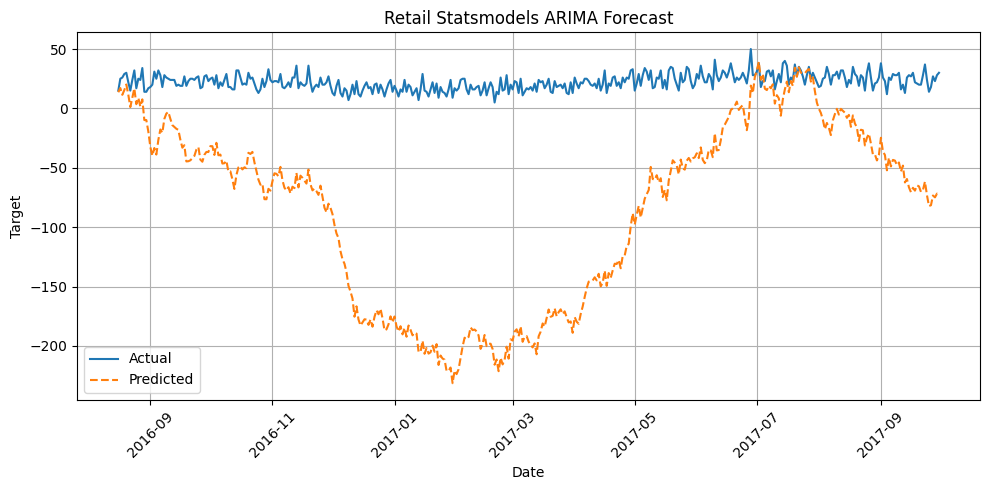

{'Dataset': 'Retail',
 'Model': 'Statsmodels ARIMA',
 'Target': 'sales',
 'RMSE': 130.16758574255752,
 'MSE': 16943.600378046063,
 'MAE': 107.8603225339533,
 'MAPE': 604.8716607673246,
 'R²': -369.7671915025259,
 'Adj_R²': -415.47821511242637,
 'TrainingTime_s': 16.759111404418945,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 475.265625}

In [6]:
# Run ARIMA Model on Retail Data

# Define parameters for ARIMA model
retail_data.name = "Retail"
target = 'sales'  # Target variable to predict
date_col = 'date'  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model # or "pmdarima"
order=(5, 1, 0)  # ARIMA order (p, d, q)

retail_arima_results = run_arima_on_dataset(
    retail_data,
    target,
    date_col,
    test_ratio,
    engine,  
    order
)

retail_arima_results

In [7]:
transportation_data = pd.read_csv('../data/dataset_transport/Baltimore_Lagged_Dataset.csv')
# transportation_data_no_lag['Month'] = transportation_data_no_lag['Month'].dt.strftime('%Y%m').astype(int)

transportation_data

,Month,Total TEUs,Lag_1,Lag_2,Lag_3,Lag_6,Lag_12
0,1/1/99,38642,41957,43415,37762,41293,38104
1,2/1/99,39418,38642,41957,43415,36461,38175
2,3/1/99,45703,39418,38642,41957,41678,46578
3,4/1/99,40671,45703,39418,38642,37762,41703
4,5/1/99,39035,40671,45703,39418,43415,40908
...,...,...,...,...,...,...,...
308,9/1/24,84143,70184,38537,24640,75099,90200
309,10/1/24,72207,84143,70184,38537,2053,104820
310,11/1/24,85966,72207,84143,70184,9938,87186
311,12/1/24,95534,85966,72207,84143,24640,97928


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')


[Before Model Training] Memory Usage: 475.62 MB | CPU Usage: 0.00%
[After Model Training] Memory Usage: 475.69 MB | CPU Usage: 0.00%

[ARIMA - Transportation] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 34826.931
MAE                 : 31660.425
MAPE (%)            : 77.570
R²                  : -3.717
Adjusted R²         : -3.985
Training Time (s)   : 0.42
Memory Used (MB)    : 0.09
Device Used         : CPU
---------------------------------------------------------------------------


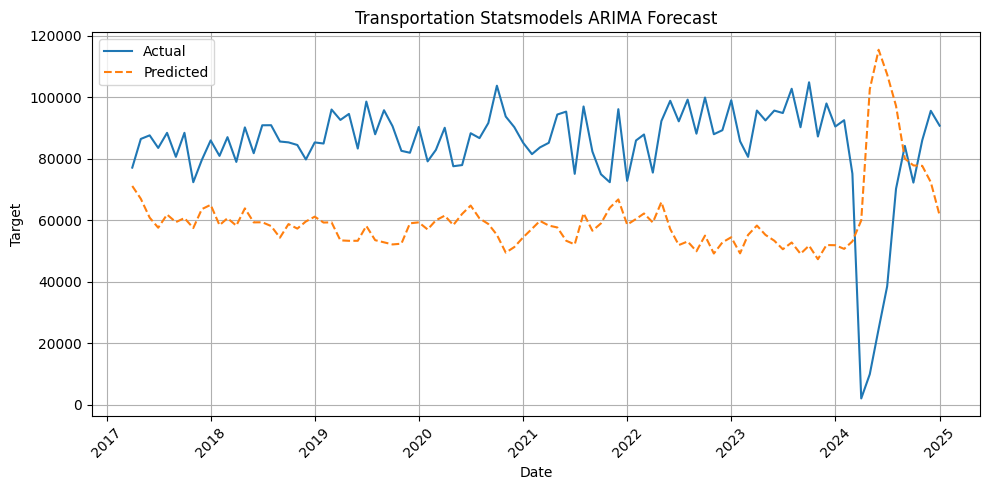

{'Dataset': 'Transportation',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Total TEUs',
 'RMSE': 34826.931026909966,
 'MSE': 1212915124.753144,
 'MAE': 31660.424529799766,
 'MAPE': 77.56973814940787,
 'R²': -3.7165331505163453,
 'Adj_R²': -3.984517988613865,
 'TrainingTime_s': 0.4157552719116211,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 475.6875}

In [8]:
# Run ARIMA Model on Transportation Data

# Define parameters for ARIMA model
transportation_data.name = "Transportation"
target = 'Total TEUs'
date_col = 'Month'  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model
order=(5, 1, 0)  # ARIMA order (p, d, q)

transportation_arima_results = run_arima_on_dataset(
    transportation_data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

transportation_arima_results

In [9]:
climate_data = pd.read_csv('../data/dataset_climate/raw/Temperature Data with Lag Features of California.csv')
# climate_data = climate_data.dropna()

# Keep only numeric columns
numeric_df = climate_data.select_dtypes(include=[np.number])

# Reattach timestamp
numeric_df['TIME'] = climate_data['TIME'].values

# Set the cleaned DataFrame back
climate_data = numeric_df

climate_data

,Mean_Temperature,lag_1,lag_12,TIME
0,7.268098,10.869001,9.869529,1982-01
1,11.191716,7.268098,11.723992,1982-02
2,10.333570,11.191716,11.615960,1982-03
3,12.718684,10.333570,14.036708,1982-04
4,16.057082,12.718684,16.333115,1982-05
...,...,...,...,...
29749,18.278763,14.200448,17.536118,2024-05
29750,23.837745,18.278763,20.671493,2024-06
29751,28.044864,23.837745,26.447245,2024-07
29752,24.305265,28.044864,25.642810,2024-08


[Before Model Training] Memory Usage: 478.13 MB | CPU Usage: 0.00%


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

[After Model Training] Memory Usage: 595.61 MB | CPU Usage: 0.00%

[ARIMA - Climate] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 2.050
MAE                 : 1.664
MAPE (%)            : nan
R²                  : 0.909
Adjusted R²         : 0.909
Training Time (s)   : 8.13
Memory Used (MB)    : 117.47
Device Used         : CPU
---------------------------------------------------------------------------


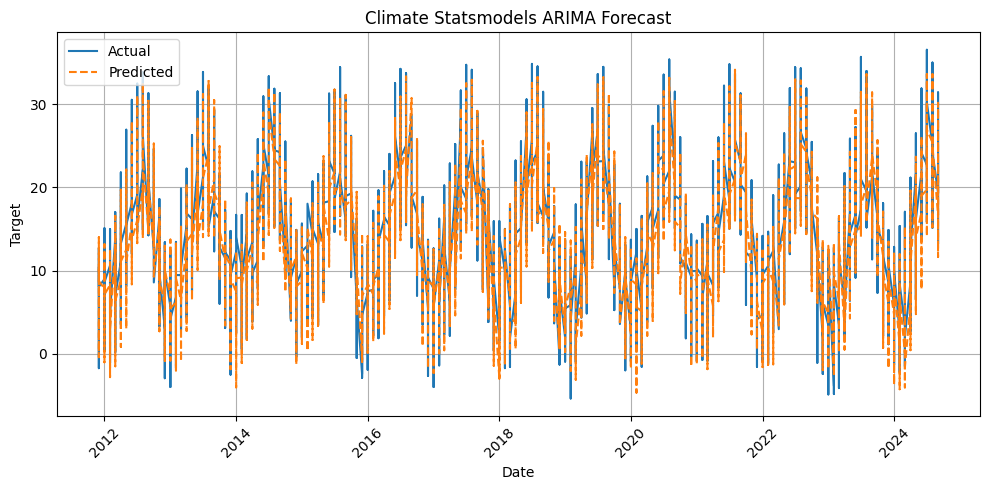

{'Dataset': 'Climate',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Mean_Temperature',
 'RMSE': 2.0495908394947007,
 'MSE': 4.200822609340593,
 'MAE': 1.6640775403718067,
 'MAPE': nan,
 'R²': 0.9094764273231235,
 'Adj_R²': 0.909456139655558,
 'TrainingTime_s': 8.134006023406982,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 595.60546875}

In [10]:
# Run ARIMA Model on Climate Data

# Define parameters for ARIMA model
climate_data.name = "Climate"
target = 'Mean_Temperature'
date_col = 'TIME'  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels"
order=(5, 1, 0)  # ARIMA order (p, d, q)

climate_arima_results = run_arima_on_dataset(
    climate_data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

climate_arima_results

In [11]:
energy_data = pd.read_csv('../data/dataset_energy/df_with_lag_indicators.csv.gz')

energy_data

,timestamp,Energy_Demand,Energy_Price,Crude_Oil_Price,Natural_Gas_Price,Rainfall,Carbon_Intensity,Renewable_Energy_Percentage,Temperature,Solar_Exposure,hour,dayofweek,month,lag_1,lag_12,lag_288,lag_576,rolling_mean_24,rolling_std_24
0,3/1/22 0:00,7294.03,4.370966,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,3/1/22 0:05,7304.76,4.507557,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.370966,NaN,NaN,NaN,NaN,NaN
2,3/1/22 0:10,7176.53,4.476996,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.507557,NaN,NaN,NaN,NaN,NaN
3,3/1/22 0:15,7247.72,4.497028,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.476996,NaN,NaN,NaN,NaN,NaN
4,3/1/22 0:20,7169.96,4.478132,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.497028,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296679,31/12/24 23:40,7467.70,4.900523,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.894326,4.730392,4.900820,4.686934,4.736257,0.093819
296680,31/12/24 23:45,7393.27,4.967171,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.900523,4.715459,4.817455,4.478132,4.745846,0.098441
296681,31/12/24 23:50,7360.53,4.888091,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.967171,4.721797,4.730304,4.590564,4.758698,0.106386
296682,31/12/24 23:55,7345.74,4.894027,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.888091,4.703113,4.713935,4.483003,4.768145,0.107428


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')


[Before Model Training] Memory Usage: 667.19 MB | CPU Usage: 0.00%


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

MLE did not converge for Energy. Details: {'fopt': 5.542594585087377, 'gopt': array([ 1.17313270e-05,  2.69828604e-07, -2.37845299e-06,  3.39177575e-06,
        1.57367630e-04, -4.37349712e-05, -6.51603216e-06,  1.01077369e-04,
        2.60813593e-06,  2.31361597e-06,  4.59898786e-06, -2.47880827e-05,
       -9.36504208e-06, -1.51326063e-05, -9.77742332e-06,  6.45491662e-05,
       -1.72191150e-06, -8.21760704e-04,  1.00704689e-04,  2.34275621e-04,
       -4.86193663e-04,  1.00699591e-03,  4.16409129e-05]), 'fcalls': 1296, 'warnflag': 1, 'converged': False, 'iterations': 50}


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[After Model Training] Memory Usage: 1785.91 MB | CPU Usage: 0.00%


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:90: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100



[ARIMA - Energy] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 1496.461
MAE                 : 1277.901
MAPE (%)            : nan
R²                  : -0.235
Adjusted R²         : -0.235
Training Time (s)   : 1191.52
Memory Used (MB)    : 1118.72
Device Used         : CPU
---------------------------------------------------------------------------


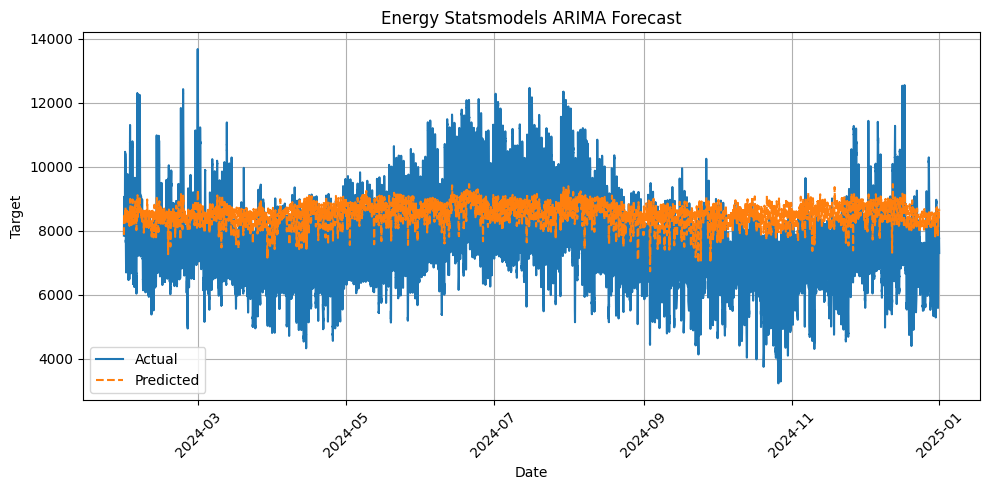

{'Dataset': 'Energy',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Energy_Demand',
 'RMSE': 1496.4610916720003,
 'MSE': 2239395.798888155,
 'MAE': 1277.9006037998354,
 'MAPE': nan,
 'R²': -0.23458842670397773,
 'Adj_R²': -0.23482473817449478,
 'TrainingTime_s': 1191.5182709693909,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 1785.90625}

In [12]:
# Run ARIMA Model on Energy Data

# Define parameters for ARIMA model
energy_data.name = "Energy"
target = 'Energy_Demand'  # Target variable to predict
date_col = 'timestamp'  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = 'statsmodels'
order = (5, 1, 0)

energy_arima_results = run_arima_on_dataset(
    energy_data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

energy_arima_results


Metrics collected and saved to:
outputs/results/output_LSTM/model_metrics_scores.csv
                            Model            Target          RMSE  \
Dataset                                                             
Finance         Statsmodels ARIMA        Close_TSLA     25.953966   
Retail          Statsmodels ARIMA             sales    130.167586   
Climate         Statsmodels ARIMA  Mean_Temperature      2.049591   
Energy          Statsmodels ARIMA     Energy_Demand   1496.461092   
Transportation  Statsmodels ARIMA        Total TEUs  34826.931027   

                         MSE           MAE        MAPE          R²  \
Dataset                                                              
Finance         6.736083e+02     24.022786         NaN    0.795197   
Retail          1.694360e+04    107.860323  604.871661 -369.767192   
Climate         4.200823e+00      1.664078         NaN    0.909476   
Energy          2.239396e+06   1277.900604         NaN   -0.234588   
Transportat

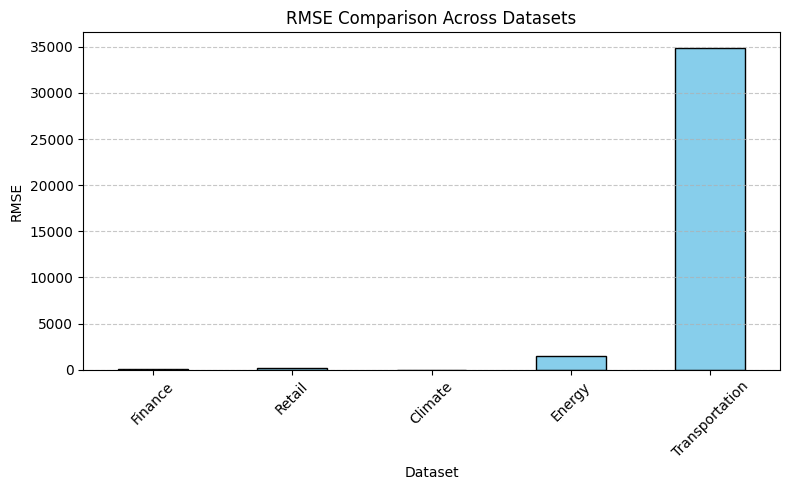

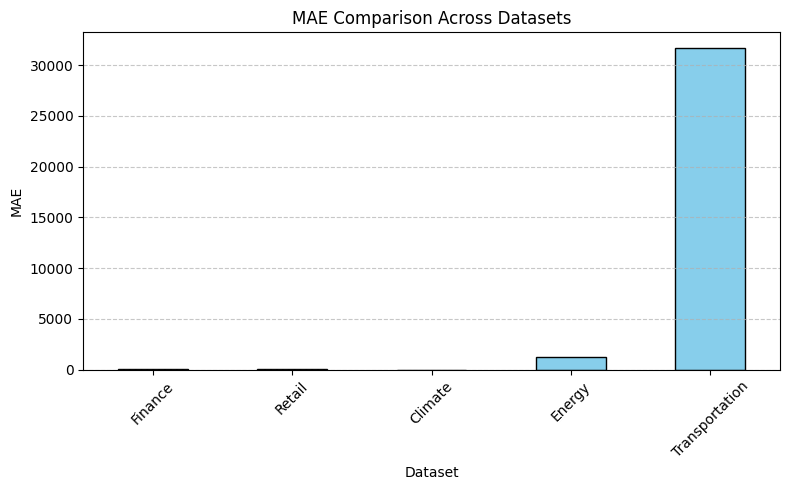

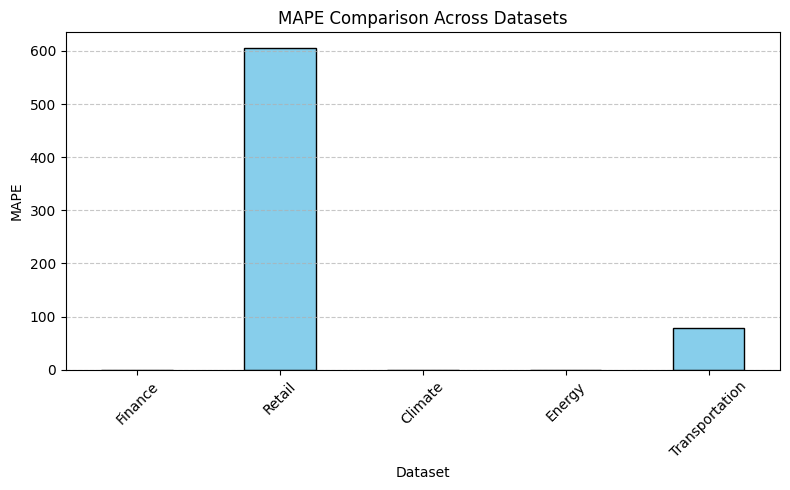

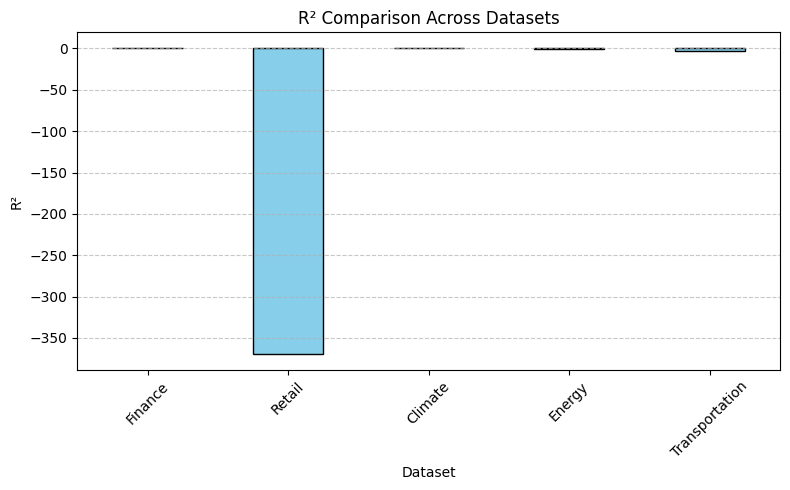

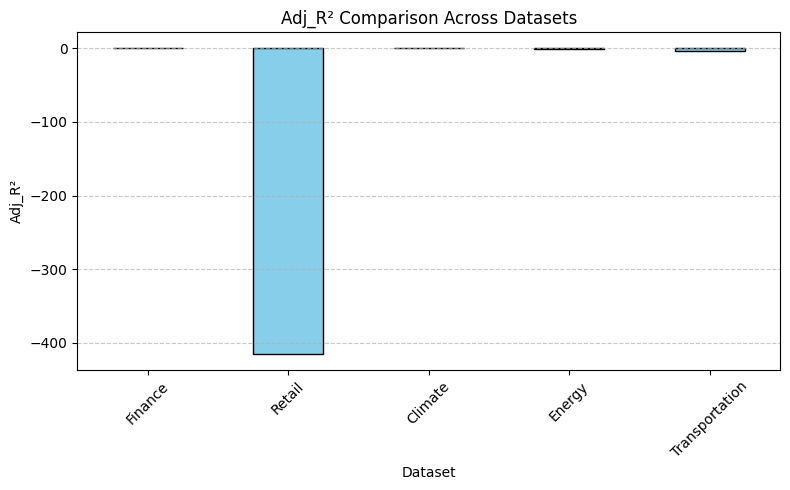

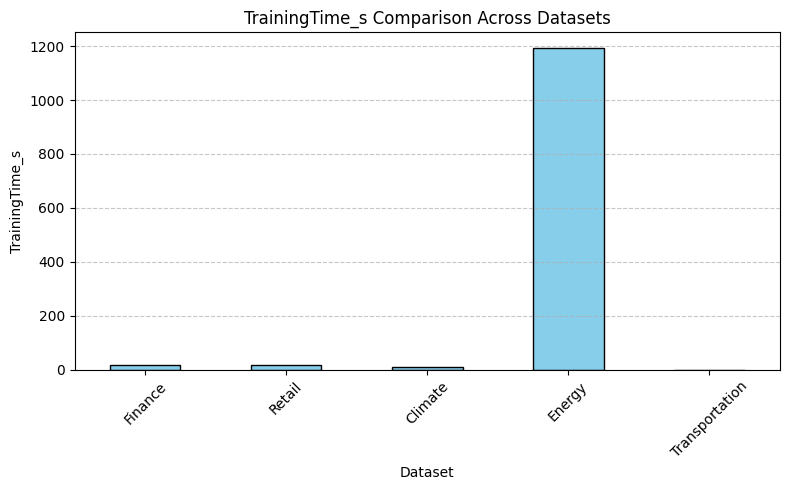

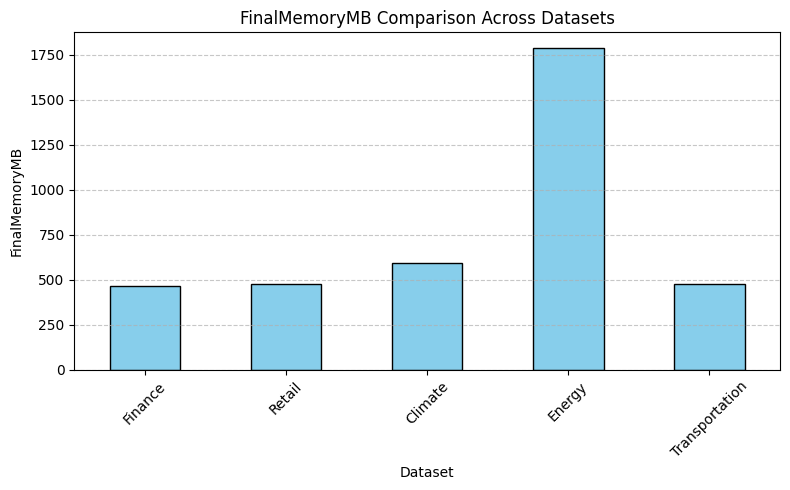

{'RMSE': 'outputs/results/output_LSTM/RMSE_comparison.png',
 'MAE': 'outputs/results/output_LSTM/MAE_comparison.png',
 'MAPE': 'outputs/results/output_LSTM/MAPE_comparison.png',
 'R²': 'outputs/results/output_LSTM/R²_comparison.png',
 'Adj_R²': 'outputs/results/output_LSTM/Adj_R²_comparison.png',
 'TrainingTime_s': 'outputs/results/output_LSTM/TrainingTime_s_comparison.png',
 'FinalMemoryMB': 'outputs/results/output_LSTM/FinalMemoryMB_comparison.png'}

In [14]:
# Step 1: Collect all result dictionaries
all_results = [
    finance_arima_results,
    retail_arima_results,
    climate_arima_results,
    energy_arima_results,
    transportation_arima_results
]

# Step 2: Convert to DataFrame
metrics_df = pd.DataFrame(all_results)
metrics_df.set_index('Dataset', inplace=True)

# Step 3: Save to CSV
output_path = "outputs/results/output_LSTM/model_metrics_scores.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
metrics_df.to_csv(output_path)

# Step 4: Display
print(f"Metrics collected and saved to:\n{output_path}")
print(metrics_df)

#	Step 5: Plotting

# Load the metrics CSV if it exists
metrics_path = "outputs/results/output_LSTM/model_metrics_scores.csv"
metrics_df = pd.read_csv(metrics_path)
metrics_df.set_index('Dataset', inplace=True)

# Plot comparison charts for each metric
metrics_to_plot = ["RMSE", "MAE", "MAPE", "R²", "Adj_R²", "TrainingTime_s", "FinalMemoryMB"]
figures = {}

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    metrics_df[metric].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"{metric} Comparison Across Datasets")
    plt.ylabel(metric)
    plt.xlabel("Dataset")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the figure
    fig_path = f"outputs/results/output_LSTM/{metric}_comparison.png"
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    plt.savefig(fig_path)
    figures[metric] = fig_path
    
    # Show the figure
    plt.show()

figures

